<a href="https://colab.research.google.com/github/fahiiim/Build-a-Small-Language-Model-From-Scrach/blob/main/Small_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build A Small Language Model From Scrach

### Installing Necessary Libraries

In [ ]:
!pip install datasets

In [ ]:
!pip install tiktoken

### Importing Libraries

In [ ]:
import datasets

from datasets import load_dataset
ds = load_dataset("roneneldan/TinyStories")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [ ]:
ds.shape

{'train': (2119719, 1), 'validation': (21990, 1)}

### Dataset Preprocessing
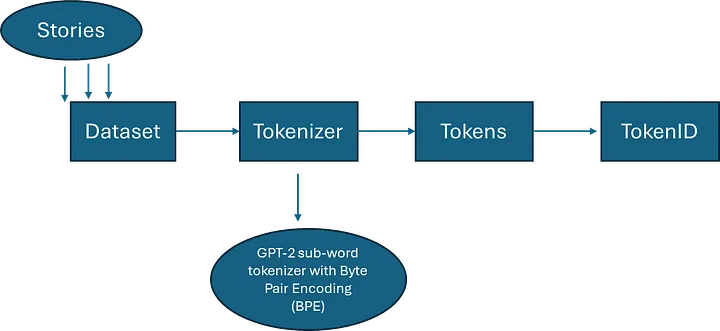

#### Importing libraries

In [ ]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

#### Tokenizer initialization
Here GPT-2 will convert raw text into integer tokens

In [ ]:
enc = tiktoken.get_encoding("gpt2")

#### Tokenization Function

In [ ]:
def process(example):
  ids = enc.encode_ordinary(example["text"])
  out = {'ids':ids, 'len': len(ids)}
  return out

#### Tokenizing the Dataset

In [ ]:
if not os.path.exists("train.bin"):
  tokenized = ds.map(
      process,
      remove_columns= ['text'],
      desc = "tokenizing the splits",
      num_proc = 8,
  )

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

#### saving Tokenized data Into binary File

In [ ]:
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16  # Safe, as GPT-2 token values < 65536
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

### create Input-Output batches for the dataset